# Setup

In [65]:
from torch.optim import lr_scheduler

No of images in training set: 835
No of images in validation set: 104
No of images in test set: 105
No of images in feeder set: 15079
Labels: ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']
Labels (feeder): ['blueTit', 'chaffinch', 'coalTit', 'goldfinch', 'greatTit', 'robin', 'starling']


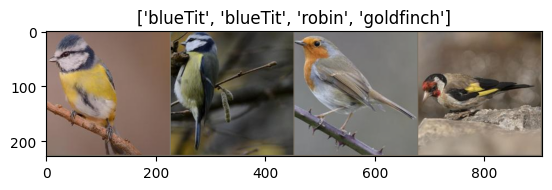

In [66]:
%run setup.ipynb 

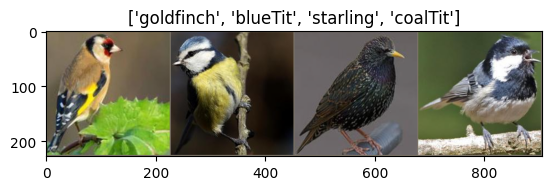

In [67]:
# start with tiny dataset until i know it works
inputs, classes = next(iter(dataloader_tiny))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_labels[x] for x in classes])

Make a train function that takes a lr scheduler as input as well

In [68]:
def train_model_scheduled(model, optimizer,scheduler, num_epoch=5, train = dataloader_train, validation= dataloader_validation):
    acc_train = []
    loss_train = []
    acc_validation = []
    loss_validation = []
    lr_rate = []
    best_acc = 0.0
    best_loss = 1.0
    best_epoch = 0
    best_model_weight = copy.deepcopy(model.state_dict())

    since = time.time()
    for epoch in range(num_epoch):
        epoch_since = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print("-"*10)
        print('Learning rate: {:n}'.format(scheduler.get_last_lr()[0]))
        lr_rate.append(scheduler.get_last_lr()[0])
        #training phase
        
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train:
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero the parameter gradients 
            optimizer.zero_grad()

            #forward
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss_train = running_loss / dataset_size_train
        epoch_acc_train = running_corrects.double() / dataset_size_train
        acc_train.append(epoch_acc_train.item())
        loss_train.append(epoch_loss_train)
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

        #validation phase
        model.eval()
        running_loss_val = 0.0
        running_corrects_val = 0
        for inputs, labels in validation:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                criterion = torch.nn.CrossEntropyLoss()
                loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)
            running_corrects_val += torch.sum(preds == labels.data)
        epoch_loss_val = running_loss_val / dataset_size_val
        epoch_acc_val = running_corrects_val.double() / dataset_size_val
        acc_validation.append(epoch_acc_val.item())
        loss_validation.append(epoch_loss_val)
        print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_val, epoch_acc_val))
        
        if(epoch_acc_val > best_acc):
            best_acc = epoch_acc_val
            best_loss = epoch_loss_val #not ness the best loss overall but the loss of the best model
            best_epoch = epoch+1
            best_model_weight = copy.deepcopy(model.state_dict())
        
        scheduler.step()
        
        time_epoch_val = time.time() - epoch_since           
        print('Epoch time {:.0f}m {:.0f}s'.format(time_epoch_val // 60, time_epoch_val % 60))
        print("-"*10)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best model had accuracy {:.4f}, loss {:.4f} at epoch {}".format(best_acc, best_loss, best_epoch))
    print("Validation accuracies:")
    print(acc_validation)
    print("Training accuracies:")
    print(acc_train)
    print(scheduler.state_dict())
    data = {"train_loss": loss_train, "val_loss": loss_validation, "train_acc": acc_train, "val_acc": acc_validation, "lr_rates": lr_rate}
    model.load_state_dict(best_model_weight)
    return model, data

In [69]:
def plot_learning_rate(lr_rates):
    num_epochs = len(lr_rates)
    plt.figure(figsize=(5,5))
    plt.plot(np.arange(1,num_epochs+1), lr_rates,'-')
    plt.xlabel('Epoch')
    plt.legend(["lr"])
    plt.ylabel('Learning rate')
    plt.title('Learning rate/Epoch')
    plt.show()

## "Linear" Learning Rate

In [70]:
training_in_here = dataloader_train
validation_in_here = dataloader_validation
num_epochs = 24

Define model, optimizer and learning rate scheduler

In [71]:
model = load_and_prep_resnet50()
optimizer = get_optimizer(model) # <-- this has lr=0.001 dont know if we should start somewhere else?
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # <- then decay this instead

# Decays the learning rate of each parameter group by linearly changing small multiplicative factor 
# default starting point is 1./3
# default end point is 0.1
linear_scheduler = lr_scheduler.LinearLR(optimizer=optimizer, total_iters=num_epochs)

In [72]:
freezeTrained_model_linear, freezeData_linear = train_model_scheduled(model=model, optimizer=optimizer, scheduler=linear_scheduler, num_epoch=num_epochs, train=training_in_here, validation=validation_in_here )

Epoch 1/24
----------
Learning rate: 0.0333333
Train Loss: 0.7873 Acc: 0.7257
Val Loss: 0.1052 Acc: 0.9808
Epoch time 2m 1s
----------

Epoch 2/24
----------
Learning rate: 0.0361111
Train Loss: 0.2740 Acc: 0.9090
Val Loss: 0.1377 Acc: 0.9519
Epoch time 1m 55s
----------

Epoch 3/24
----------
Learning rate: 0.0388889
Train Loss: 0.2040 Acc: 0.9293
Val Loss: 0.0841 Acc: 0.9808
Epoch time 1m 55s
----------

Epoch 4/24
----------
Learning rate: 0.0416667
Train Loss: 0.2317 Acc: 0.9150
Val Loss: 0.1348 Acc: 0.9519
Epoch time 1m 49s
----------

Epoch 5/24
----------
Learning rate: 0.0444444
Train Loss: 0.1552 Acc: 0.9425
Val Loss: 0.1236 Acc: 0.9519
Epoch time 1m 48s
----------

Epoch 6/24
----------
Learning rate: 0.0472222
Train Loss: 0.2019 Acc: 0.9377
Val Loss: 0.2024 Acc: 0.9327
Epoch time 1m 48s
----------

Epoch 7/24
----------
Learning rate: 0.05
Train Loss: 0.1452 Acc: 0.9473
Val Loss: 0.0774 Acc: 0.9712
Epoch time 1m 47s
----------

Epoch 8/24
----------
Learning rate: 0.0527778


In [73]:
unfreeze_layers(freezeTrained_model_linear)
# man skal vel også reload learning rate scheduler ?? Synes ikke de gør til tø tho...
model_linear, model_linear_data = train_model_scheduled(model=freezeTrained_model_linear, optimizer=optimizer, scheduler=linear_scheduler, num_epoch=num_epochs, train=training_in_here, validation=validation_in_here)

Epoch 1/24
----------
Learning rate: 0.1
Train Loss: 2.2682 Acc: 0.1713
Val Loss: 2.9897 Acc: 0.2019
Epoch time 5m 12s
----------

Epoch 2/24
----------
Learning rate: 0.1
Train Loss: 1.9484 Acc: 0.1964
Val Loss: 2.2453 Acc: 0.2115
Epoch time 5m 11s
----------

Epoch 3/24
----------
Learning rate: 0.1
Train Loss: 1.8979 Acc: 0.2204
Val Loss: 4.3691 Acc: 0.2885
Epoch time 5m 12s
----------

Epoch 4/24
----------
Learning rate: 0.1
Train Loss: 1.8725 Acc: 0.2299
Val Loss: 2.5615 Acc: 0.2596
Epoch time 5m 11s
----------

Epoch 5/24
----------
Learning rate: 0.1
Train Loss: 1.8164 Acc: 0.2659
Val Loss: 2.7145 Acc: 0.1635
Epoch time 5m 9s
----------

Epoch 6/24
----------
Learning rate: 0.1
Train Loss: 1.7219 Acc: 0.3090
Val Loss: 2.3067 Acc: 0.3558
Epoch time 5m 12s
----------

Epoch 7/24
----------
Learning rate: 0.1
Train Loss: 1.6946 Acc: 0.3210
Val Loss: 1.7182 Acc: 0.2596
Epoch time 5m 11s
----------

Epoch 8/24
----------
Learning rate: 0.1
Train Loss: 1.5720 Acc: 0.3737
Val Loss: 2.

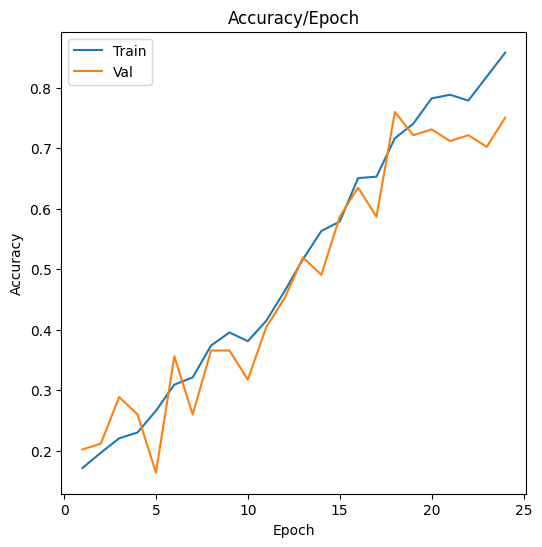

In [74]:
plot_accuracies(model_linear_data["train_acc"], model_linear_data["val_acc"], ["Train", "Val"])

[[13  0  1  0  0  0  1]
 [ 1 10  2  0  0  0  2]
 [ 2  0 13  0  0  0  0]
 [ 1  0  0 14  0  0  0]
 [ 1  0  5  0  9  0  0]
 [ 0  1  0  0  0 13  1]
 [ 2  0  3  0  0  0 10]]
Accuracy 78.0952380952381


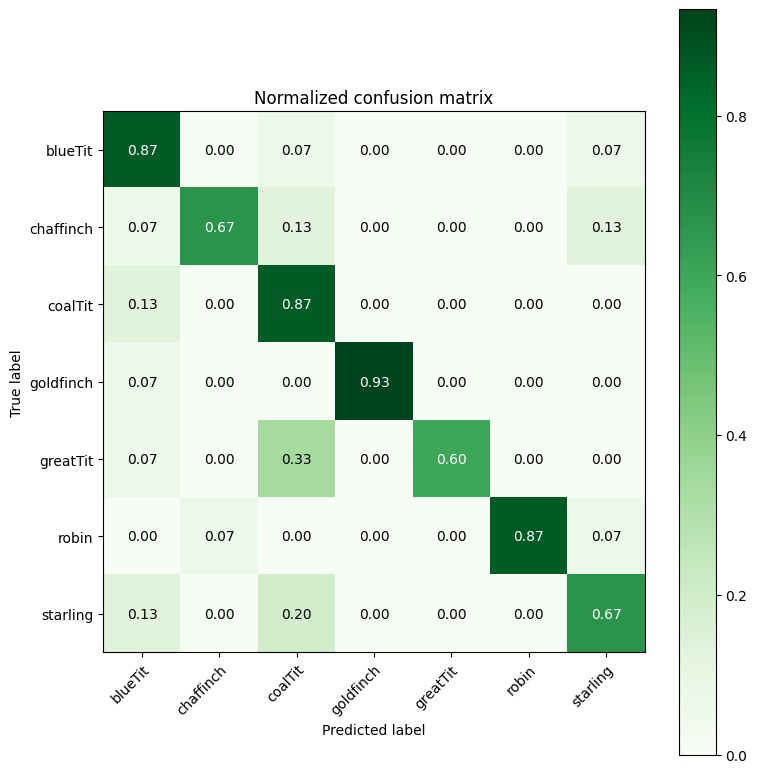

In [75]:
truel, predl = makeAll(dataloader_test, model_linear, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

## Cyclic learning rate

In [81]:
model = load_and_prep_resnet50()
optimizer = get_optimizer(model)
# cycles the learning rate between two boundaries with a constant frequency. 
# changes the learning rate after every batch. step should be called after a batch has been used for training.
cycle_scheduler = lr_scheduler.CyclicLR(optimizer=optimizer,base_lr=0.001, max_lr=0.1)

In [82]:
freezeTrained_model_cycle, freeze_data_cycle = train_model_scheduled(model=model, optimizer=optimizer, scheduler=cycle_scheduler, num_epoch=24, train=dataloader_train, validation=dataloader_validation )

Epoch 1/24
----------
Learning rate: 0.001
Train Loss: 1.6865 Acc: 0.5317
Val Loss: 1.3891 Acc: 0.7788
Epoch time 1m 60s
----------

Epoch 2/24
----------
Learning rate: 0.0010495
Train Loss: 1.2300 Acc: 0.8228
Val Loss: 1.0080 Acc: 0.8654
Epoch time 2m 1s
----------

Epoch 3/24
----------
Learning rate: 0.001099
Train Loss: 0.9629 Acc: 0.8695
Val Loss: 0.7313 Acc: 0.9231
Epoch time 2m 12s
----------

Epoch 4/24
----------
Learning rate: 0.0011485
Train Loss: 0.7928 Acc: 0.8958
Val Loss: 0.6069 Acc: 0.9423
Epoch time 1m 53s
----------

Epoch 5/24
----------
Learning rate: 0.001198
Train Loss: 0.6896 Acc: 0.9042
Val Loss: 0.5039 Acc: 0.9231
Epoch time 1m 52s
----------

Epoch 6/24
----------
Learning rate: 0.0012475
Train Loss: 0.5959 Acc: 0.9054
Val Loss: 0.4904 Acc: 0.9519
Epoch time 1m 52s
----------

Epoch 7/24
----------
Learning rate: 0.001297
Train Loss: 0.5360 Acc: 0.9413
Val Loss: 0.4177 Acc: 0.9519
Epoch time 1m 52s
----------

Epoch 8/24
----------
Learning rate: 0.0013465
Tr

In [83]:
unfreeze_layers(freezeTrained_model_cycle)
# man skal vel også reload learning rate scheduler ?? Synes ikke de gør til tø tho...
model_cycle, model_cycle_data = train_model_scheduled(model=freezeTrained_model_cycle, optimizer=optimizer, scheduler=cycle_scheduler, num_epoch=num_epochs, train=training_in_here, validation=validation_in_here)

Epoch 1/24
----------
Learning rate: 0.002188
Train Loss: 0.2073 Acc: 0.9437
Val Loss: 0.1626 Acc: 0.9519
Epoch time 5m 24s
----------

Epoch 2/24
----------
Learning rate: 0.0022375
Train Loss: 0.0933 Acc: 0.9749
Val Loss: 0.0536 Acc: 0.9904
Epoch time 5m 20s
----------

Epoch 3/24
----------
Learning rate: 0.002287
Train Loss: 0.0332 Acc: 0.9940
Val Loss: 0.0365 Acc: 0.9808
Epoch time 5m 38s
----------

Epoch 4/24
----------
Learning rate: 0.0023365
Train Loss: 0.0223 Acc: 0.9940
Val Loss: 0.0516 Acc: 0.9808
Epoch time 5m 36s
----------

Epoch 5/24
----------
Learning rate: 0.002386
Train Loss: 0.0152 Acc: 0.9964
Val Loss: 0.0352 Acc: 0.9808
Epoch time 6m 7s
----------

Epoch 6/24
----------
Learning rate: 0.0024355
Train Loss: 0.0201 Acc: 0.9964
Val Loss: 0.0180 Acc: 0.9904
Epoch time 5m 52s
----------

Epoch 7/24
----------
Learning rate: 0.002485
Train Loss: 0.0232 Acc: 0.9928
Val Loss: 0.0284 Acc: 1.0000
Epoch time 5m 38s
----------

Epoch 8/24
----------
Learning rate: 0.0025345

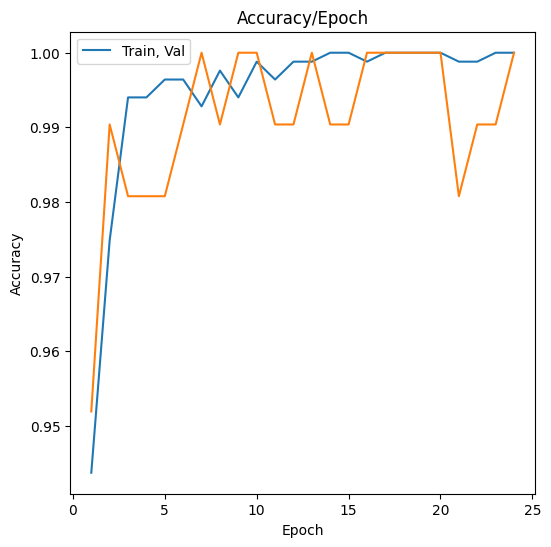

In [84]:
plot_accuracies(model_cycle_data["train_acc"], model_cycle_data["val_acc"], ["Train, Val"])

[[15  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0]
 [ 0  0 14  0  0  0  1]
 [ 0  0  0 15  0  0  0]
 [ 0  0  1  0 14  0  0]
 [ 0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0 15]]
Accuracy 98.09523809523809


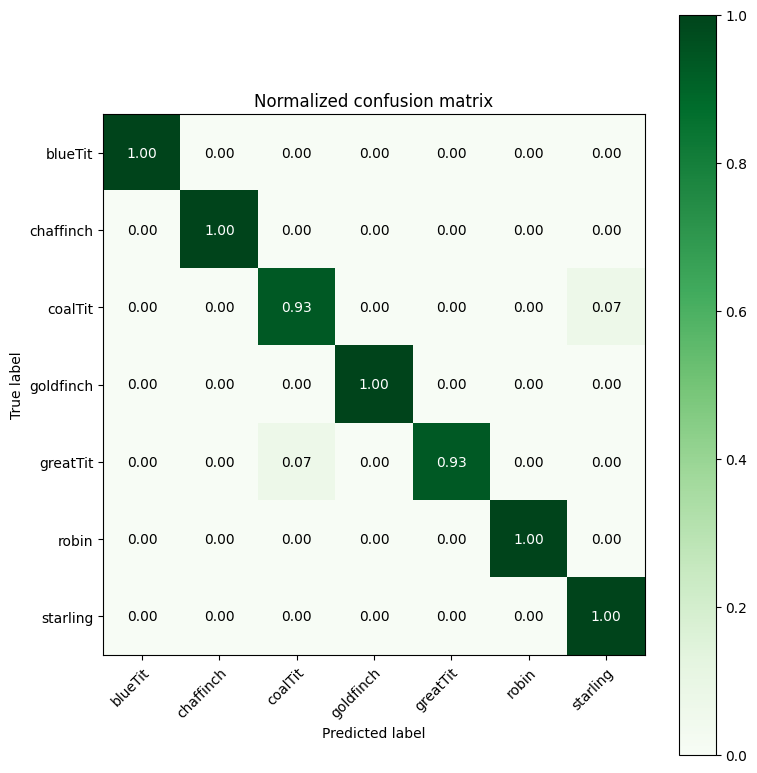

In [85]:
truel, predl = makeAll(dataloader_test, model_cycle, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

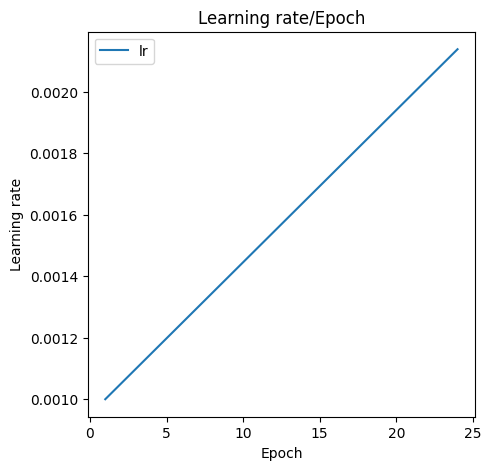

[0.001, 0.0010495000000000166, 0.001098999999999989, 0.0011485000000000056, 0.0011979999999999782, 0.0012474999999999947, 0.0012970000000000113, 0.0013464999999999838, 0.0013960000000000003, 0.0014455000000000169, 0.0014949999999999894, 0.001544500000000006, 0.0015939999999999787, 0.0016434999999999952, 0.0016930000000000118, 0.001742499999999984, 0.0017920000000000006, 0.0018415000000000172, 0.00189099999999999, 0.0019405000000000065, 0.0019899999999999788, 0.0020394999999999953, 0.002089000000000012, 0.0021384999999999846]


In [88]:
plot_learning_rate(freeze_data_cycle["lr_rates"])
print(freeze_data_cycle["lr_rates"])

In [91]:
torch.save({"linear_model": model_linear.state_dict(), "linear_model_data": model_linear_data }, "linear.tar")
torch.save({"model_cycle": model_cycle.state_dict(), "model_cycle_data": model_cycle_data }, "Cycle.tar")

c:\Users\annek\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


[[15  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0]
 [ 0  0 14  0  0  0  1]
 [ 0  0  0 15  0  0  0]
 [ 0  0  1  0 14  0  0]
 [ 0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0 15]]
Accuracy 98.09523809523809


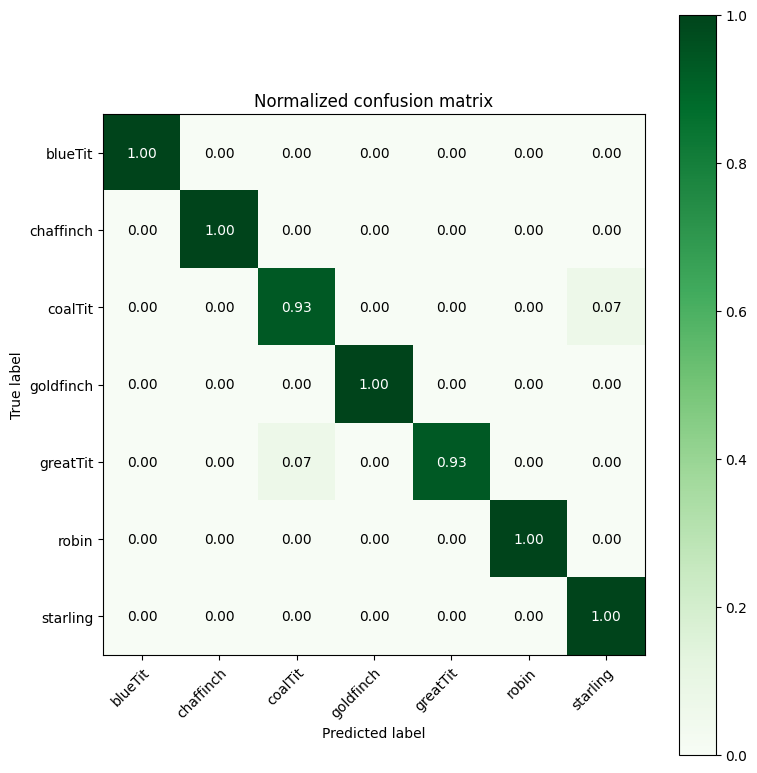

In [90]:
loaded = torch.load("linearAndCycle.tar", weights_only=True)
loadModel = load_and_prep_resnet50()
loadModel.load_state_dict(loaded["model_cycle"])
loadModel.eval()
truel, predl = makeAll(dataloader_test, loadModel, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

[[ 506    2   46   14  754   12  744]
 [  94 1410  354  251  102  169 1172]
 [  41    1 1189   20   99    9  487]
 [   3    8   42 1921    2    2   22]
 [  53    0  222   21 1084    8  645]
 [   0    4    1    2    5  564  852]
 [   1    0   67   11    5   18 2040]]
Accuracy 57.78897804894224


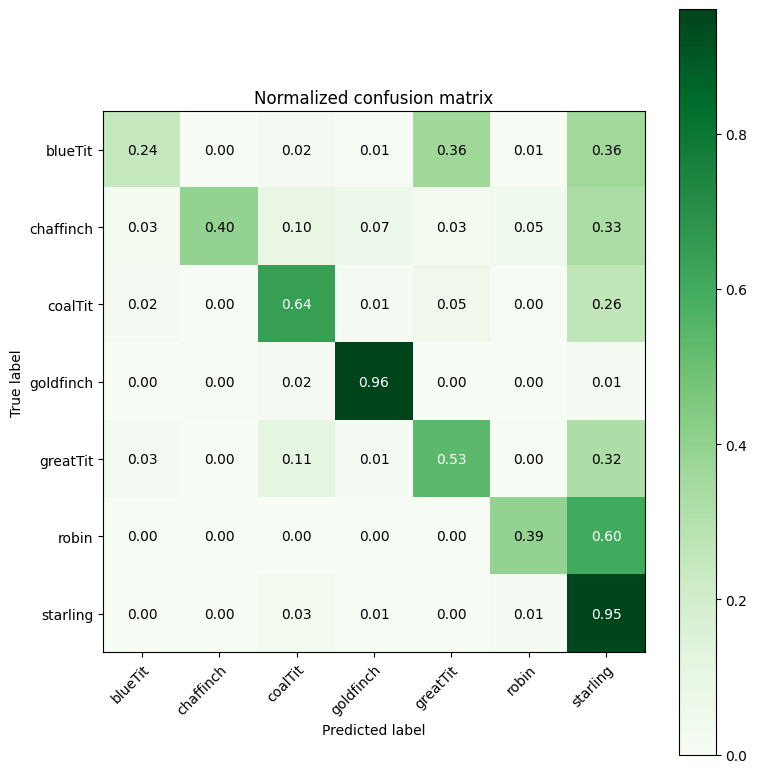

In [92]:
truel, predl = makeAll(dataloader_feeder, model_cycle, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))

[[ 506    2   46   14  754   12  744]
 [  94 1410  354  251  102  169 1172]
 [  41    1 1189   20   99    9  487]
 [   3    8   42 1921    2    2   22]
 [  53    0  222   21 1084    8  645]
 [   0    4    1    2    5  564  852]
 [   1    0   67   11    5   18 2040]]
Accuracy 57.78897804894224


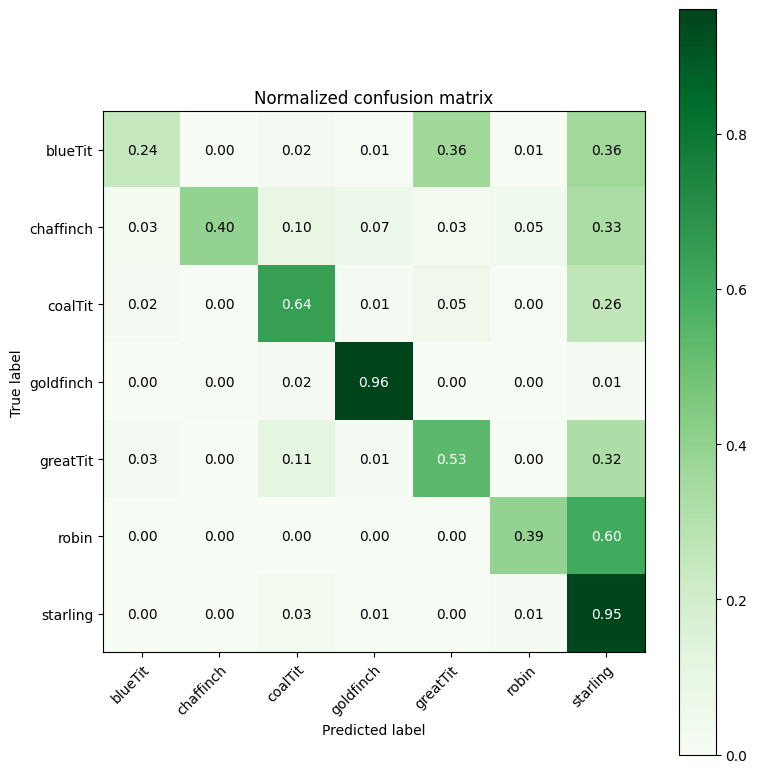

In [93]:
model_cycle.eval()
truel, predl = makeAll(dataloader_feeder, model_cycle, device)
plot_confusion_matrix(truel, predl, class_labels, normalize=True)
print("Accuracy", (np.sum(predl==truel)/predl.size * 100))